<h1><center><strong>Tarefas</strong></center></h1>

Notebook respondendo as tarefas propostas para a atividade:

**1.** Plotar gráficos dos preços e retornos e tecer comentários sobre possível
heterocedasticidade condicional;

**2.** Ajustar modelos de volatilidade univariados e escolher o mais adequado (pode usar
critérios de informação e/ou validação cruzada);


**3.** Prever a volatilidade um passo à frente usando o modelo selecionado no item anterior;


**4.** Comparar volatilidades entre os retornos selecionados (quais são maiores e menores,
relacionando com algum storytelling);


**5.** Calcular retorno do portfólio (usando pesos designados inicialmente) e ajustar um modelo
de volatilidade para o mesmo, realizando a previsão um passo à frente da volatilidade do
portfólio;


**6.** Calcular betas individuais usando regressão simples (estático) e tecer comentários;


**7.** Calcular beta estático de um portfolio contendo os ativos selecionados e pesos
determinados por vocês, assumindo as hipóteses do CAPM;


**8.** Fazer uma otimização dos pesos do seu portfólio inicial e repetir as etapas 5 e 7,
comparando o seu portfólio inicial com o otimizado. A otimização será abordada no lab.


### **Bibliotecas**

In [1]:
# Importando Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from IPython.display import display, clear_output
from arch import arch_model
from itertools import product

### **Dados**

Importando histórico de dados das empresas analisadas.

In [2]:
# Lista dos nomes dos arquivos CSV
arquivos = ['df_AZEV4', 'df_ETER3', 'df_OPCT3', 'df_PETR4', 'df_USIM5', 'df_VALE3']

# Criando um dicionário onde a chave é o nome do arquivo e o valor é o DataFrame correspondente
dataframes = {nome: pd.read_csv(f"data\\{nome}.csv", parse_dates=True, index_col="Date") for nome in arquivos}

# Convertendo os índices de cada DataFrame para datetime com timezone UTC
for df in dataframes.values():
    df.index = pd.to_datetime(df.index, utc=True)

### **Gráficos e Funções**

Para manter o notebook mais claro e legível, todos os gráficos e funções serão criados nesta seção.

In [3]:
def plot_closing_prices(dataframes):
    # Configurando o tema escuro
    plt.style.use('dark_background')

    # Configurando o gráfico
    plt.figure(figsize=(10, 6))

    # Definindo uma lista de cores
    cores = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

    # Plotando cada série de dados com uma cor específica
    for (nome, df), cor in zip(dataframes.items(), cores):
        plt.plot(df['Close'], label=nome.split("_")[-1], color=cor)

    # Adicionando título e rótulos
    plt.title('Gráfico de Preços de Fechamento')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')

    # Mostrando a legenda à direita e fora do gráfico
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))

    # Mostrar o gráfico
    plt.show()

In [4]:
def plot_closing_price(dataframes, acao_selecionada):
    # Configurando o tema escuro
    plt.style.use('dark_background')

    # Verifica se a ação selecionada está no dicionário de dataframes
    if acao_selecionada not in dataframes:
        print(f"Ação selecionada '{acao_selecionada}' não encontrada.")
        return

    # Configurando o gráfico
    plt.figure(figsize=(10, 6))

    # Plotando os dados da ação selecionada
    plt.plot(dataframes[acao_selecionada]['Close'], label=acao_selecionada.split("_")[-1], color='cyan')

    # Adicionando título e rótulos
    plt.title(f'Gráfico de Preço de Fechamento - {acao_selecionada.split("_")[-1]}')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')

    # Mostrando a legenda
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))

    # Mostrar o gráfico
    plt.show()

In [5]:
def plot_closing_price_interactive(dataframes):
    # Configurando o tema escuro
    plt.style.use('dark_background')
    
    # Criação de um widget Dropdown para seleção da ação
    dropdown = widgets.Dropdown(
        options=list(dataframes.keys()),
        value=list(dataframes.keys())[0],
        description='Selecione a ação:',
        disabled=False,
    )
    
    # Criando dicionario de cor para cada ação
    cores = {
        "df_AZEV4": "blue",
        "df_ETER3": "green",
        "df_OPCT3": "red",
        "df_PETR4": "cyan",
        "df_USIM5": "magenta",
        "df_VALE3": "yellow" 
    }

    # Função para plotar o gráfico da ação selecionada
    def plot_graph(acao_selecionada):
        plt.figure(figsize=(10, 6))
        plt.plot(dataframes[acao_selecionada]['Close'], label=acao_selecionada.split("_")[-1], color=cores[acao_selecionada])
        plt.title(f'Gráfico de Preço de Fechamento - {acao_selecionada.split("_")[-1]}')
        plt.xlabel('Data')
        plt.ylabel('Preço de Fechamento')
        plt.legend(loc='upper left', bbox_to_anchor=(1,1))
        plt.show()
    
    # Chama plot_graph quando uma nova ação é selecionada
    def on_dropdown_change(change):
        clear_output(wait=True)
        display(dropdown)  # Redisplay dropdown para mantê-lo visível
        plot_graph(change['new'])
    
    # Observa mudanças no valor do dropdown
    dropdown.observe(on_dropdown_change, names='value')
    
    # Exibe o dropdown
    display(dropdown)
    # Exibe o gráfico inicial
    plot_graph(dropdown.value)


In [6]:
def plot_return(stock):
    # Limpa a figura atual
    plt.clf()
    # Criando a figura e os eixos
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Definindo cores
    cores = {
        "df_AZEV4": "blue",
        "df_ETER3": "green",
        "df_OPCT3": "red",
        "df_PETR4": "cyan",
        "df_USIM5": "magenta",
        "df_VALE3": "yellow" 
    }

    # Plotando os logs de retornos
    dataframes[stock]["Log_Return"].plot(ax=ax1, color=cores[stock])
    ax1.set_title(f'Log Returns of {stock}')
    ax1.set_ylabel('Log Return')

    # Plotando a função de autocorrelação
    plot_acf(dataframes[stock]["Log_Return"].dropna(), ax=ax2, lags=20, color=cores[stock])
    ax2.set_title('Autocorrelation Function')

    plt.tight_layout()
    plt.show()


In [7]:
def plot_return_square(stock):
    # Limpa a figura atual
    plt.clf()
    # Criando a figura e os eixos
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Definindo cores
    cores = {
        "df_AZEV4": "blue",
        "df_ETER3": "green",
        "df_OPCT3": "red",
        "df_PETR4": "cyan",
        "df_USIM5": "magenta",
        "df_VALE3": "yellow" 
    }

    # Plotando os logs de retornos
    dataframes[stock]["Log_Return_square"].plot(ax=ax1, color=cores[stock])
    ax1.set_title(f'Log Returns of {stock}')
    ax1.set_ylabel('Log Return')

    # Plotando a função de autocorrelação
    plot_acf(dataframes[stock]["Log_Return_square"].dropna(), ax=ax2, lags=20, color=cores[stock])
    ax2.set_title('Autocorrelation Function')

    plt.tight_layout()
    plt.show()

### **Tarefas**

#### **1.** Plotar gráficos dos preços e retornos e tecer comentários sobre possível heterocedasticidade condicional;

Primeiramente plotando os gráficos de preços:

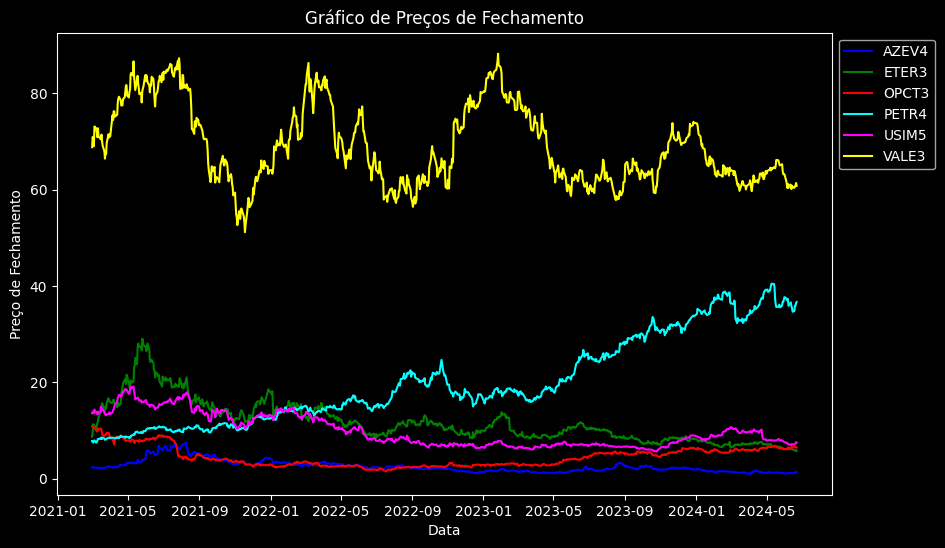

In [8]:
# Plotando Preços de Fechamento diários
plot_closing_prices(dataframes)

Como temos ações com diferentes faixas de preços, os preços também podem ser visualizados de acordo com cada tick no gráfico abaixo:

Dropdown(description='Selecione a ação:', options=('df_AZEV4', 'df_ETER3', 'df_OPCT3', 'df_PETR4', 'df_USIM5',…

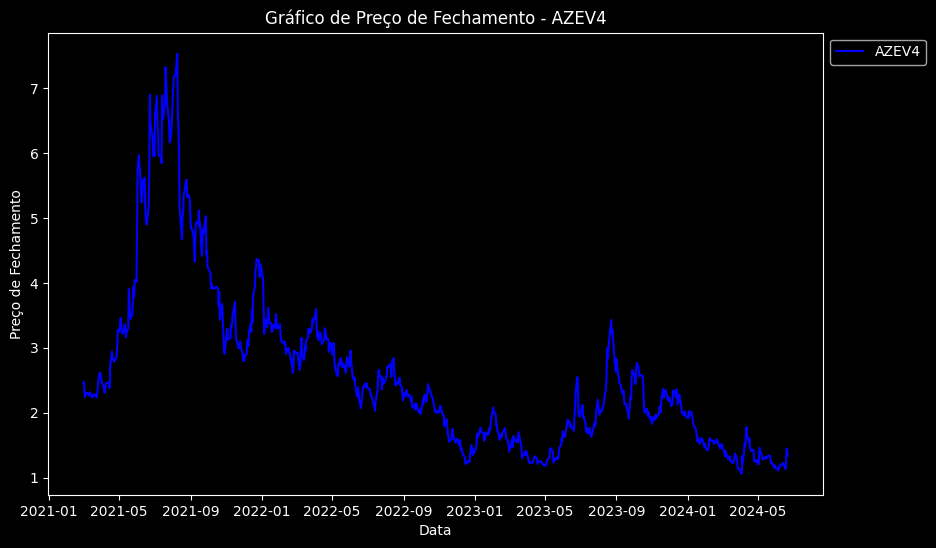

In [9]:
plot_closing_price_interactive(dataframes)

O próximo passo para esta primeira questão é calcular os logs dos retornos para cada uma das ações e plotar o gráfico para verificar o comportamento.

In [10]:
# Calculando os valores de log do retorno para cada um dos dataframes do dicionario dataframes
dfs_names_list = list(dataframes.keys())

for name in dfs_names_list:
    df_intermed = dataframes[name].copy()
    df_intermed["log_close"] = np.log(df_intermed["Close"])
    df_intermed["Log_Return"] = df_intermed["log_close"].diff().dropna()
    df_intermed.drop(columns=["log_close"], inplace=True)
    dataframes[name] = df_intermed

Com os logs retornos calculados, podemos plotar os gráficos abaixo:

In [11]:
# Widget para selecionar a ação
widgets.interact(plot_return, stock=widgets.Dropdown(options=dataframes.keys(), value='df_AZEV4', description='Stock:'))

interactive(children=(Dropdown(description='Stock:', options=('df_AZEV4', 'df_ETER3', 'df_OPCT3', 'df_PETR4', …

<function __main__.plot_return(stock)>

Observando os gráficos da Função de Autocorrelação (ACF) dos log-retornos dos ativos analisados, nota-se um comportamento muito similar ao de um ruído branco. Isso indica que os log-retornos são praticamente independentes ao longo do tempo, sugerindo que a média dos retornos pode ser constante e que não há padrões temporais evidentes nos próprios retornos.

No entanto, a ausência de autocorrelação significativa nos retornos não implica necessariamente a ausência de heterocedasticidade condicional. Por conta disso, podemos analisar o quadrado dos retornos para identificar essa heterocedasticidade.

In [12]:
# Calculando os valores de log do retorno para cada um dos dataframes do dicionario dataframes
dfs_names_list = list(dataframes.keys())

for name in dfs_names_list:
    df_intermed = dataframes[name].copy()
    df_intermed["Log_Return_square"] = df_intermed["Log_Return"] ** 2
    dataframes[name] = df_intermed

In [13]:
# Widget para selecionar a ação
widgets.interact(plot_return_square, stock=widgets.Dropdown(options=dataframes.keys(), value='df_AZEV4', description='Stock:'))

interactive(children=(Dropdown(description='Stock:', options=('df_AZEV4', 'df_ETER3', 'df_OPCT3', 'df_PETR4', …

<function __main__.plot_return_square(stock)>

**Questionar em aula**: Mesmo utilizando retornos ao quadrado, aparentemente não existe autocorrelação em nenhum lag da série.

#### **2.** Ajustar modelos de volatilidade univariados e escolher o mais adequado (pode usar critérios de informação e/ou validação cruzada);

Primeiramente será criado o grid de combinações de hiperparametros.

In [14]:
# Definindo os valores dos hiperparâmetros
p_values = range(1, 6)  # p de 1 a 6
q_values = range(1, 3)  # q de 1 a 3
dist_values = ['normal', 't']  # distribuições

# Gerando todas as combinações possíveis
combinations = list(product(p_values, q_values, dist_values))

# Criando a lista de dicionários
grid_params = [{'p': p, 'q': q, 'dist': dist} for p, q, dist in combinations]


grid_params

[{'p': 1, 'q': 1, 'dist': 'normal'},
 {'p': 1, 'q': 1, 'dist': 't'},
 {'p': 1, 'q': 2, 'dist': 'normal'},
 {'p': 1, 'q': 2, 'dist': 't'},
 {'p': 2, 'q': 1, 'dist': 'normal'},
 {'p': 2, 'q': 1, 'dist': 't'},
 {'p': 2, 'q': 2, 'dist': 'normal'},
 {'p': 2, 'q': 2, 'dist': 't'},
 {'p': 3, 'q': 1, 'dist': 'normal'},
 {'p': 3, 'q': 1, 'dist': 't'},
 {'p': 3, 'q': 2, 'dist': 'normal'},
 {'p': 3, 'q': 2, 'dist': 't'},
 {'p': 4, 'q': 1, 'dist': 'normal'},
 {'p': 4, 'q': 1, 'dist': 't'},
 {'p': 4, 'q': 2, 'dist': 'normal'},
 {'p': 4, 'q': 2, 'dist': 't'},
 {'p': 5, 'q': 1, 'dist': 'normal'},
 {'p': 5, 'q': 1, 'dist': 't'},
 {'p': 5, 'q': 2, 'dist': 'normal'},
 {'p': 5, 'q': 2, 'dist': 't'}]

Com o grid criado, podemos iterar para cada ativo analisado e encontrar a melhor combinação de hiperparametros.

In [15]:
resultados_final = []

for key in dataframes.keys():
    # Copiar o DataFrame original
    df_it = dataframes[key].copy()

    # Retirando valores NaN
    df_it.dropna(inplace=True)

    # Remover valores NaN e infinitos
    df_it = df_it[np.isfinite(df_it["Log_Return"])]

    results = []
    for i in range(0, len(grid_params)):
        # Ajustar o modelo GARCH
        garch = arch_model(df_it["Log_Return"], vol='Garch', p=grid_params[i]["p"], q=grid_params[i]["q"], dist=grid_params[i]["dist"], rescale=False)

        # Estimar o modelo
        model_fit = garch.fit(disp="off")

        # Adicionando aos resultados
        results.append({
            "AIC": model_fit.aic,
            "BIC": model_fit.bic,
            "params": grid_params[i]
        })
    
    # Transformando em dataframe
    results_df = pd.DataFrame(results)

    # Ordenando pela métrica AIC
    results_df = results_df.sort_values("AIC", ascending=True)

    # Adicionando aos resultados finais
    resultados_final.append({
        "Stock": key,
        "Best_AIC": results_df.iloc[0]["AIC"],
        "Best_BIC": results_df.iloc[0]["BIC"],
        "Best_param": results_df.iloc[0]["params"]
    })

    
# Exibindo os resultados
df_resultados_final = pd.DataFrame(resultados_final)

df_resultados_final

c:\Users\muril\Documents\MeusProjetos\financial_analytics_final\f_a_f_env\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\muril\Documents\MeusProjetos\financial_analytics_final\f_a_f_env\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\muril\Documents\MeusProjetos\financial_analytics_final\f_a_f_env\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,Stock,Best_AIC,Best_BIC,Best_param
0,df_AZEV4,-2677.839988,-2654.257014,"{'p': 1, 'q': 1, 'dist': 't'}"
1,df_ETER3,-3193.154861,-3155.422103,"{'p': 4, 'q': 1, 'dist': 't'}"
2,df_OPCT3,-3255.894492,-3227.594924,"{'p': 1, 'q': 2, 'dist': 't'}"
3,df_PETR4,-3978.087144,-3935.637791,"{'p': 4, 'q': 2, 'dist': 't'}"
4,df_USIM5,-3770.417716,-3742.118147,"{'p': 1, 'q': 2, 'dist': 't'}"
5,df_VALE3,-4176.567465,-4152.984491,"{'p': 1, 'q': 1, 'dist': 't'}"


Com isso temos os melhores parametros para cada ativo e podemos ajustar o modelo otimizado.

##### AZEV4

In [16]:
# Ajustando o melhor modelo para o ativo AZEV4
df_AZEV4 = dataframes["df_AZEV4"].copy()
df_AZEV4 = df_AZEV4[np.isfinite(df_AZEV4["Log_Return"])]
azev4_model = arch_model(df_AZEV4["Log_Return"], vol="GARCH", p=df_resultados_final.iloc[0,3]["p"],
                          q=df_resultados_final.iloc[0,3]["q"],
                            dist=df_resultados_final.iloc[0,3]["dist"], rescale=False)

azev4_fit = azev4_model.fit(disp="off")

azev4_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                   Log_Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                1343.92
Distribution:      Standardized Student's t   AIC:                          -2677.84
Method:                  Maximum Likelihood   BIC:                          -2654.26
                                              No. Observations:                  826
Date:                      Sat, Jun 22 2024   Df Residuals:                      825
Time:                              14:14:15   Df Model:                            1
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -3.2002e-03  1.488e-03     -2.150  3.155e-02 [-6.118e-03,-2.829e-04]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.8199e-04  6.865e-04      1.430      0.153 [-3.635e-04,2.327e-03]
alpha[1]       0.1349  6.538e-02      2.063  3.913e-02    [6.724e-03,  0.263]
beta[1]        0.4929      0.308      1.600      0.109      [ -0.111,  1.097]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.8071      0.729      6.592  4.334e-11 [  3.378,  6.236]
========================================================================

Covariance estimator: robust
"""

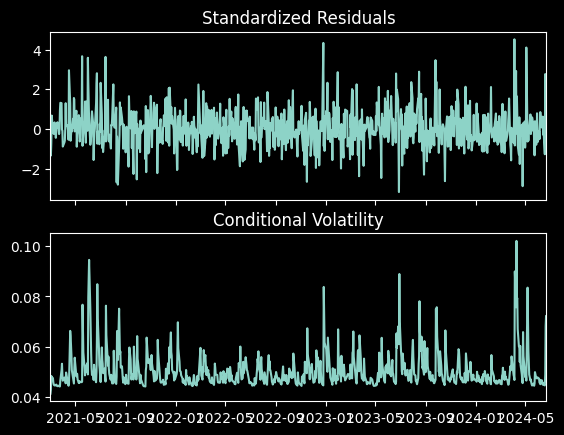

In [17]:
fig = azev4_fit.plot()

##### ETER3

In [18]:
# Ajustando o melhor modelo para o ativo AZEV4
df_ETER3 = dataframes["df_ETER3"].copy()
df_ETER3 = df_ETER3[np.isfinite(df_ETER3["Log_Return"])]
eter3_model = arch_model(df_ETER3["Log_Return"], vol="GARCH", p=(df_resultados_final.iloc[1,3]["p"] -1), 
                          q=df_resultados_final.iloc[1,3]["q"],
                            dist=df_resultados_final.iloc[1,3]["dist"], rescale=False)

eter3_fit = eter3_model.fit(disp="off")

eter3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                   Log_Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                1591.24
Distribution:      Standardized Student's t   AIC:                          -3168.47
Method:                  Maximum Likelihood   BIC:                          -3135.46
                                              No. Observations:                  826
Date:                      Sat, Jun 22 2024   Df Residuals:                      825
Time:                              14:14:15   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.5052e-03  1.073e-03     -1.403      0.161 [-3.608e-03,5.976e-04]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.1593e-05  3.718e-05      0.850      0.395 [-4.128e-05,1.045e-04]
alpha[1]       0.0167  3.353e-02      0.497      0.619 [-4.906e-02,8.239e-02]
alpha[2]       0.0167  7.789e-02      0.214      0.831      [ -0.136,  0.169]
alpha[3]       0.0167  5.301e-02      0.314      0.753   [-8.723e-02,  0.121]
beta[1]        0.9299  7.482e-02     12.428  1.840e-35      [  0.783,  1.077]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.4618      4.080      1.339      0.181 [ -2.535, 13.459]
========================================================================

Covariance estimator: robust
"""

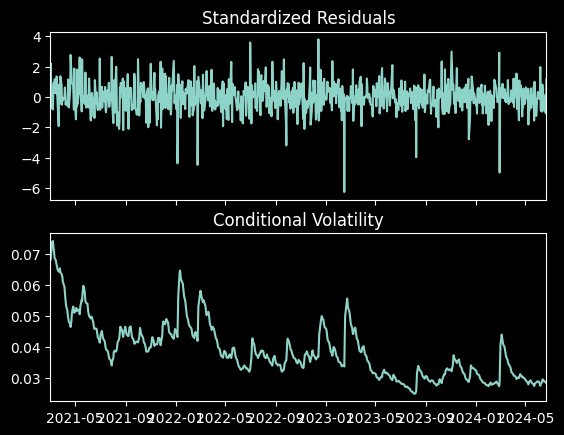

In [19]:
fig = eter3_fit.plot()

##### OPCT3

In [20]:
# Ajustando o melhor modelo para o ativo AZEV4
df_OPCT3 = dataframes["df_OPCT3"].copy()
df_OPCT3 = df_OPCT3[np.isfinite(df_OPCT3["Log_Return"])]
opct3_model = arch_model(df_OPCT3["Log_Return"], vol="GARCH", p=df_resultados_final.iloc[2,3]["p"],
                          q=df_resultados_final.iloc[2,3]["q"],
                            dist=df_resultados_final.iloc[2,3]["dist"], rescale=False)

opct3_fit = opct3_model.fit(disp="off")

opct3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                   Log_Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                1633.95
Distribution:      Standardized Student's t   AIC:                          -3255.89
Method:                  Maximum Likelihood   BIC:                          -3227.59
                                              No. Observations:                  826
Date:                      Sat, Jun 22 2024   Df Residuals:                      825
Time:                              14:14:15   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -4.2315e-04  1.101e-03     -0.384      0.701 [-2.582e-03,1.735e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.3152e-11  1.856e-08  7.086e-04      0.999 [-3.637e-08,3.639e-08]
alpha[1]       0.0229  2.559e-03      8.969  2.979e-19  [1.793e-02,2.796e-02]
beta[1]        0.2512      0.150      1.670  9.502e-02   [-4.371e-02,  0.546]
beta[2]        0.7237      0.152      4.766  1.884e-06      [  0.426,  1.021]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.6964      1.929      3.471  5.193e-04 [  2.915, 10.478]
========================================================================

Covariance estimator: robust
"""

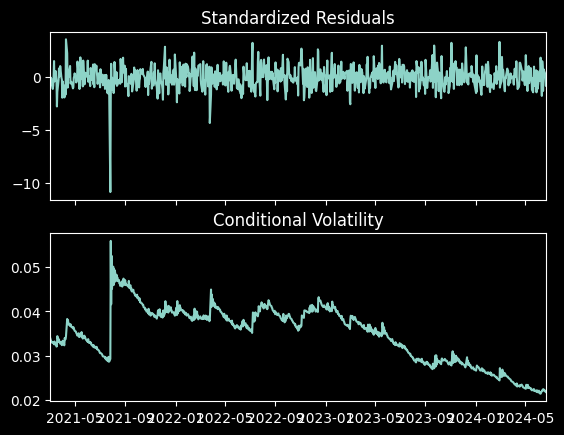

In [21]:
fig = opct3_fit.plot()

##### PETR4

In [22]:
# Ajustando o melhor modelo para o ativo AZEV4
df_PETR4 = dataframes["df_PETR4"].copy()
df_PETR4 = df_PETR4[np.isfinite(df_PETR4["Log_Return"])]
petr4_model = arch_model(df_PETR4["Log_Return"], vol="GARCH", p=df_resultados_final.iloc[3,3]["p"],
                          q=df_resultados_final.iloc[3,3]["q"],
                            dist=df_resultados_final.iloc[3,3]["dist"], rescale=False)

petr4_fit = petr4_model.fit(disp="off")

petr4_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                   Log_Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                1998.04
Distribution:      Standardized Student's t   AIC:                          -3978.09
Method:                  Maximum Likelihood   BIC:                          -3935.64
                                              No. Observations:                  826
Date:                      Sat, Jun 22 2024   Df Residuals:                      825
Time:                              14:14:15   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.3547e-03  7.072e-04      3.330  8.696e-04 [9.686e-04,3.741e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.4923e-05  3.146e-06      7.923  2.319e-15  [1.876e-05,3.109e-05]
alpha[1]   2.6658e-03  1.813e-02      0.147      0.883 [-3.287e-02,3.820e-02]
alpha[2]       0.0123  2.552e-02      0.481      0.630 [-3.773e-02,6.230e-02]
alpha[3]       0.0161  2.226e-02      0.724      0.469 [-2.751e-02,5.976e-02]
alpha[4]       0.0113  2.552e-02      0.442      0.658 [-3.874e-02,6.130e-02]
beta[1]    2.7437e-08      0.126  2.178e-07      1.000      [ -0.247,  0.247]
beta[2]        0.8998      0.125      7.224  5.030e-13      [  0.656,  1.144]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             9.3996      5.352      1.756  7.904e-02 [ -1.090, 19.889]
========================================================================

Covariance estimator: robust
"""

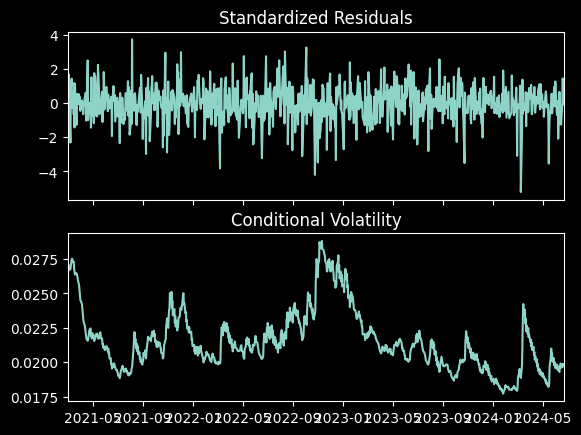

In [23]:
fig = petr4_fit.plot()

##### USIM5

In [24]:
# Ajustando o melhor modelo para o ativo AZEV4
df_USIM5 = dataframes["df_USIM5"].copy()
df_USIM5 = df_USIM5[np.isfinite(df_USIM5["Log_Return"])]
usim5_model = arch_model(df_USIM5["Log_Return"], vol="GARCH", p=df_resultados_final.iloc[4,3]["p"],
                          q=df_resultados_final.iloc[4,3]["q"],
                            dist=df_resultados_final.iloc[4,3]["dist"], rescale=False)

usim5_fit = usim5_model.fit(disp="off")

usim5_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                   Log_Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                1891.21
Distribution:      Standardized Student's t   AIC:                          -3770.42
Method:                  Maximum Likelihood   BIC:                          -3742.12
                                              No. Observations:                  826
Date:                      Sat, Jun 22 2024   Df Residuals:                      825
Time:                              14:14:15   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -7.5349e-04  7.769e-04     -0.970      0.332 [-2.276e-03,7.693e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.6994e-06  2.649e-07     25.294 3.709e-141 [6.180e-06,7.218e-06]
alpha[1]       0.0717  2.897e-02      2.474  1.335e-02   [1.489e-02,  0.128]
beta[1]        0.2744      0.168      1.635      0.102  [-5.453e-02,  0.603]
beta[2]        0.6455      0.166      3.878  1.054e-04     [  0.319,  0.972]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.7850      1.206      4.797  1.614e-06 [  3.421,  8.149]
========================================================================

Covariance estimator: robust
"""

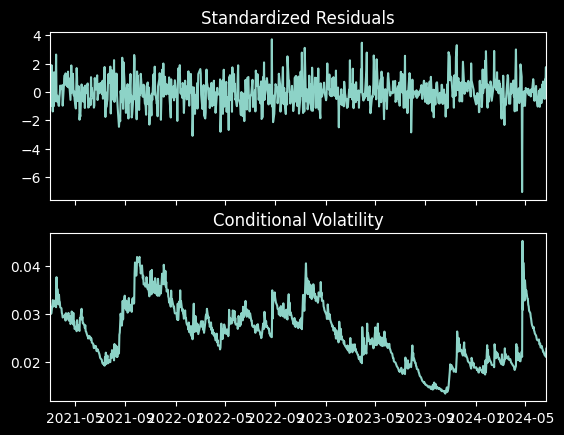

In [25]:
fig = usim5_fit.plot()

##### VALE3

In [26]:
# Ajustando o melhor modelo para o ativo AZEV4
df_VALE3 = dataframes["df_USIM5"].copy()
df_VALE3 = df_VALE3[np.isfinite(df_VALE3["Log_Return"])]
vale3_model = arch_model(df_VALE3["Log_Return"], vol="GARCH", p=df_resultados_final.iloc[5,3]["p"],
                          q=df_resultados_final.iloc[5,3]["q"],
                            dist=df_resultados_final.iloc[5,3]["dist"], rescale=False)

vale3_fit = vale3_model.fit(disp="off")

vale3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                   Log_Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                1889.01
Distribution:      Standardized Student's t   AIC:                          -3768.03
Method:                  Maximum Likelihood   BIC:                          -3744.44
                                              No. Observations:                  826
Date:                      Sat, Jun 22 2024   Df Residuals:                      825
Time:                              14:14:16   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -7.1508e-04  7.702e-04     -0.928      0.353 [-2.225e-03,7.945e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.3722e-05  8.755e-08    156.729      0.000 [1.355e-05,1.389e-05]
alpha[1]       0.0500  1.381e-02      3.620  2.943e-04 [2.293e-02,7.707e-02]
beta[1]        0.9300  1.279e-02     72.737      0.000     [  0.905,  0.955]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.1717      1.743      3.542  3.973e-04 [  2.756,  9.587]
========================================================================

Covariance estimator: robust
"""

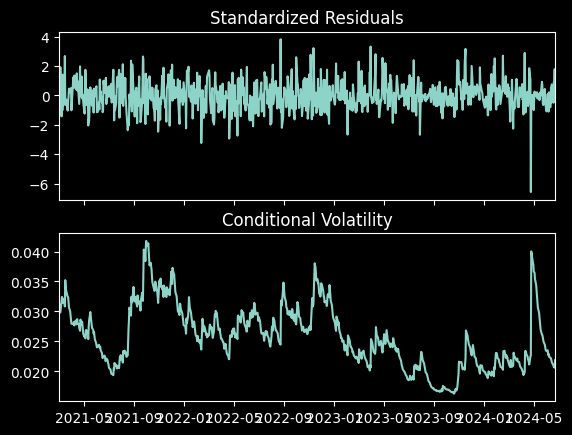

In [27]:
fig = vale3_fit.plot()

#### **3.** Prever a volatilidade um passo à frente usando o modelo selecionado no item anterior;

In [28]:
azev4_forecast = azev4_fit.forecast(horizon=1)
eter3_forecast = eter3_fit.forecast(horizon=1)
opct3_forecast = opct3_fit.forecast(horizon=1)
petr4_forecast = petr4_fit.forecast(horizon=1)
usim5_forecast = usim5_fit.forecast(horizon=1)
vale3_forecast = vale3_fit.forecast(horizon=1)


df_forecast_horizon_1 = {
    "Ativo": ["AZEV4", "ETER3", "OPCT3", "PETR4", "USIM5", "VALE3"],
    "Volatilidade_date": [azev4_forecast.variance.index.date,
                     eter3_forecast.variance.index.date,
                     opct3_forecast.variance.index.date,
                     petr4_forecast.variance.index.date,
                     usim5_forecast.variance.index.date,
                     vale3_forecast.variance.index.date],
    "Volatilidade": [azev4_forecast.variance["h.1"].iloc[0],
                     eter3_forecast.variance["h.1"].iloc[0],
                     opct3_forecast.variance["h.1"].iloc[0],
                     petr4_forecast.variance["h.1"].iloc[0],
                     usim5_forecast.variance["h.1"].iloc[0],
                     vale3_forecast.variance["h.1"].iloc[0]]
}


df_forecast_horizon_1 = pd.DataFrame(df_forecast_horizon_1)

df_forecast_horizon_1

,Ativo,Volatilidade_date,Volatilidade
0,AZEV4,[2024-06-21],0.002998
1,ETER3,[2024-06-21],0.000812
2,OPCT3,[2024-06-21],0.000465
3,PETR4,[2024-06-21],0.000387
4,USIM5,[2024-06-21],0.000441
5,VALE3,[2024-06-21],0.000462


#### **4.** Comparar volatilidades entre os retornos selecionados (quais são maiores e menores, relacionando com algum storytelling);

In [29]:
df_forecast_horizon_1 = df_forecast_horizon_1.sort_values("Volatilidade", ascending=False)

df_forecast_horizon_1

,Ativo,Volatilidade_date,Volatilidade
0,AZEV4,[2024-06-21],0.002998
1,ETER3,[2024-06-21],0.000812
2,OPCT3,[2024-06-21],0.000465
5,VALE3,[2024-06-21],0.000462
4,USIM5,[2024-06-21],0.000441
3,PETR4,[2024-06-21],0.000387


- **AZEV4**: Este ativo apresentou a maior volatilidade dentre os analisados, com um valor de 0.004594. Isso sugere que os retornos de AZEV4 têm maior variabilidade e, portanto, maior risco. Investidores interessados em AZEV4 devem estar preparados para possíveis flutuações significativas no preço.

- **ETER3 e OPCT3**: Com volatilidades de 0.000557 e 0.000482, respectivamente, esses ativos têm volatilidades relativamente baixas. Isso indica retornos mais estáveis e menor risco comparado ao AZEV4. Investidores conservadores podem achar esses ativos mais atraentes devido à menor incerteza em seus retornos.

- **USIM5, PETR4 e VALE3**: Estes três ativos apresentam volatilidades bastante semelhantes, variando entre 0.000457 e 0.000436. A proximidade das suas volatilidades sugere que esses ativos têm retornos com padrões de variação semelhantes. USIM5, PETR4 e VALE3 podem ser considerados ativos de baixo risco em relação à volatilidade, o que pode atrair investidores que buscam estabilidade.


A análise das volatilidades dos retornos dos ativos selecionados revelou que AZEV4 (Azevedo & Travassos) apresentou uma volatilidade significativamente maior em comparação com outros ativos. Para entender as razões por trás dessa diferença, foram pesquisadas notícias recentes sobre a empresa.

****

**Fatores Contribuintes para a Alta Volatilidade de AZEV4**
- Aumento de Capital Recente:

Azevedo & Travassos concluiu recentemente uma segunda rodada de aumento de capital, captando R$ 153,26 milhões por meio da emissão de novas ações ordinárias e preferenciais. Este movimento pode ter gerado uma maior demanda e volatilidade nas ações devido ao aumento da liquidez e ao interesse dos investidores​ ([SpaceMoney](https://www.spacemoney.com.br/investimentos/azevedo-e-travassos-azev4-capta-r-15326-milhoes-em-nova-rodada/))​.

- Adição ao Índice Small Caps da B3:

A empresa foi incluída no Índice Small Caps da B3, o que aumenta a visibilidade e atrai novos investidores. Esse reconhecimento pode aumentar a liquidez das ações, mas também pode contribuir para maiores oscilações nos preços devido ao maior volume de negociações​ ([Azevedo Travassos](https://azevedotravassos.com.br/noticias/2024/05/07/estamos-azev4-no-indice-small-caps-da-b3/))​.

- Movimentos Estratégicos e Investimentos:

A compra de ações pelo investidor Nelson Tanure e seus fundos associados também influenciou significativamente a volatilidade. A notícia da compra de ações por parte de investidores renomados geralmente impacta o preço das ações, causando flutuações mais amplas no curto prazo​ ([SpaceMoney](https://www.spacemoney.com.br/noticias/azevedo-e-travassos-azev4-nelson-tanure-compra-acoes/))​.

A volatilidade elevada de AZEV4 pode ser atribuída a eventos corporativos recentes, como aumentos de capital, inclusão em índices de destaque e compras significativas por investidores influentes. Esses fatores combinados aumentam a visibilidade e a liquidez das ações, mas também trazem uma maior variação nos preços devido às reações dos investidores a essas notícias.

#### **5.** Calcular retorno do portfólio (usando pesos designados inicialmente) e ajustar um modelo de volatilidade para o mesmo, realizando a previsão um passo à frente da volatilidade do portfólio;

Para uma primeira análise, utilizaremos os seguintes pesos para cada ativo dentro do portfólio:

|**Ativo**|**Pesos (%)**|
|-|-|
|AZEV4|16|
|ETER3|16|
|OPCT3|17|
|PETR4|17|
|USIM5|17|
|VALE3|17|

In [30]:
# Selecionar a coluna de retornos logarítmicos
log_returns = {
    "AZEV4": df_AZEV4['Log_Return'],
    "ETER3": df_ETER3['Log_Return'],
    "OPCT3": df_OPCT3['Log_Return'],
    "PETR4": df_PETR4['Log_Return'],
    "USIM5": df_USIM5['Log_Return'],
    "VALE3": df_VALE3['Log_Return']
}

# Criar um dataframe combinado dos retornos
returns_df = pd.DataFrame(log_returns)

# Definido pesos
weights = {
    "AZEV4": 0.16,
    "ETER3": 0.16,
    "OPCT3": 0.17,
    "PETR4": 0.17,
    "USIM5": 0.17,
    "VALE3": 0.17
}

# Calcular os retornos do portfólio
portfolio_returns = returns_df.dot(pd.Series(weights))

portfolio_returns

Date
2021-03-02 03:00:00+00:00    0.026397
2021-03-03 03:00:00+00:00    0.007417
2021-03-04 03:00:00+00:00   -0.017486
2021-03-05 03:00:00+00:00    0.026056
2021-03-08 03:00:00+00:00   -0.042887
                               ...   
2024-06-17 03:00:00+00:00   -0.016001
2024-06-18 03:00:00+00:00    0.031992
2024-06-19 03:00:00+00:00    0.023756
2024-06-20 03:00:00+00:00   -0.003651
2024-06-21 03:00:00+00:00    0.000860
Length: 826, dtype: float64

In [31]:
# Otimizando parametros modelos para modelo de volatilidade 
results_portifolio = []
for i in range(0, len(grid_params)):
    # Ajustar o modelo GARCH
    garch = arch_model(portfolio_returns.values, vol='Garch', p=grid_params[i]["p"],
                        q=grid_params[i]["q"],
                        dist=grid_params[i]["dist"],
                        rescale=False)

    # Estimar o modelo
    model_fit = garch.fit(disp="off")

    # Adicionando aos resultados
    results_portifolio.append({
        "AIC": model_fit.aic,
        "BIC": model_fit.bic,
        "params": grid_params[i]
    })


df_results_portifolio = pd.DataFrame(results_portifolio)

df_results_portifolio.sort_values("AIC", ascending=True, inplace=True)

df_results_portifolio.head(5)

c:\Users\muril\Documents\MeusProjetos\financial_analytics_final\f_a_f_env\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,AIC,BIC,params
1,-4131.392172,-4107.809198,"{'p': 1, 'q': 1, 'dist': 't'}"
5,-4129.392143,-4101.092575,"{'p': 2, 'q': 1, 'dist': 't'}"
9,-4127.392367,-4094.376203,"{'p': 3, 'q': 1, 'dist': 't'}"
2,-4124.438200,-4100.855226,"{'p': 1, 'q': 2, 'dist': 'normal'}"
0,-4123.725639,-4104.859260,"{'p': 1, 'q': 1, 'dist': 'normal'}"


In [32]:
# Ajustando modelo final para o portifólio
portifolio_final_model = arch_model(portfolio_returns.values, vol='Garch', p=df_results_portifolio.iloc[0,2]["p"],
                        q=df_results_portifolio.iloc[0,2]["q"],
                        dist=df_results_portifolio.iloc[0,2]["dist"],
                        rescale=False)

portifolio_final_fit = portifolio_final_model.fit(disp="off")

portifolio_final_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                2070.70
Distribution:      Standardized Student's t   AIC:                          -4131.39
Method:                  Maximum Likelihood   BIC:                          -4107.81
                                              No. Observations:                  826
Date:                      Sat, Jun 22 2024   Df Residuals:                      825
Time:                              14:14:16   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.4655e-05  6.549e-04      0.129      0.897 [-1.199e-03,1.368e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.5504e-07  1.269e-09    516.312      0.000 [6.526e-07,6.575e-07]
alpha[1]       0.0213  6.837e-03      3.122  1.799e-03 [7.942e-03,3.474e-02]
beta[1]        0.9766  6.538e-03    149.376      0.000     [  0.964,  0.989]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu            19.3284      5.233      3.693  2.213e-04 [  9.071, 29.585]
========================================================================

Covariance estimator: robust
"""

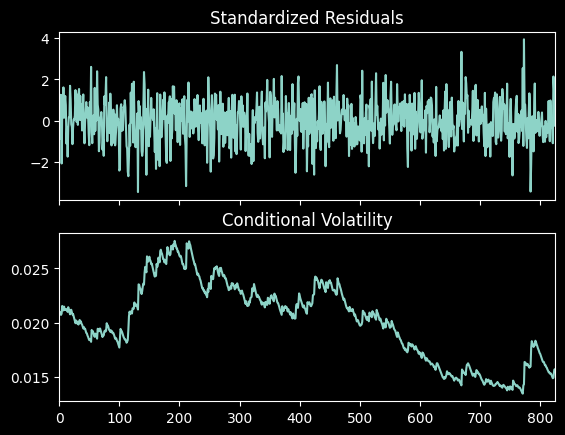

In [33]:
fig = portifolio_final_fit.plot()

In [34]:
portifolio_final_forecast = portifolio_final_fit.forecast(horizon=1)

portifolio_final_forecast.variance

,h.1
825,0.000236


#### **6.** Calcular betas individuais usando regressão simples (estático) e tecer comentários;

Primeiramente, serão importados os dados do mercado de referência, que neste caso do projeto é o Índice Bovespa.


$$r_i = \alpha + \beta*r_m + \epsilon$$

In [35]:
# Carregando base de dados IBOVESPA
df_IBOVESPA = pd.read_csv("data\\df_IBOVESPA.csv")

df_IBOVESPA["log_close"] = np.log(df_IBOVESPA["Close"])
df_IBOVESPA["Log_Return"] = df_IBOVESPA["log_close"].diff().dropna()
df_IBOVESPA.drop(columns=["log_close"], inplace=True)

df_IBOVESPA

,Date,Open,High,Low,Close,Adj Close,Volume,Log_Return
0,2021-03-01,110036.0,112445.0,110036.0,110335.0,110335.0,11239900,NaN
1,2021-03-02,110328.0,112428.0,107319.0,111540.0,111540.0,14823200,0.010862
2,2021-03-03,111529.0,112398.0,107466.0,111184.0,111184.0,15144300,-0.003197
3,2021-03-04,111191.0,114433.0,111163.0,112690.0,112690.0,14221600,0.013454
4,2021-03-05,112690.0,115504.0,112504.0,115202.0,115202.0,13254800,0.022046
...,...,...,...,...,...,...,...,...
822,2024-06-17,119663.0,119663.0,118685.0,119138.0,119138.0,7380600,-0.004389
823,2024-06-18,119138.0,120109.0,118872.0,119630.0,119630.0,8100100,0.004121
824,2024-06-19,119630.0,120383.0,118960.0,120261.0,120261.0,5646300,0.005261
825,2024-06-20,120267.0,121607.0,120156.0,120446.0,120446.0,8659500,0.001537


In [43]:
X = df_IBOVESPA["Log_Return"].dropna()
X = X.values.reshape(-1, 1)
model = LinearRegression()
betas_list = []

for key,df in dataframes.items():
    y = df["Log_Return"].dropna()
    model.fit(X, y)
    beta = model.coef_[0]
    betas_list.append({"Ativo": key.split("_")[-1],
                       "Beta": beta})
    

# Transformando em um dataframe
df_betas_ativos = pd.DataFrame(betas_list)

# Ordenando
df_betas_ativos.sort_values("Beta", inplace=True)

df_betas_ativos

,Ativo,Beta
5,VALE3,0.861502
2,OPCT3,1.040086
3,PETR4,1.125483
4,USIM5,1.268265
1,ETER3,1.288218
0,AZEV4,1.455563


Analisando os betas calculados, observamos que a Vale apresentou o menor risco quando comparada ao retorno do mercado, enquanto a ação AZEV4 possui o maior risco associado.

#### **7.** Calcular beta estático de um portfolio contendo os ativos selecionados e pesos determinados por vocês, assumindo as hipóteses do CAPM;

In [42]:
# Calculando beta para o portifólio
model = LinearRegression()
y = portfolio_returns
X = df_IBOVESPA["Log_Return"].dropna()
X = X.values.reshape(-1, 1)
model.fit(X, y)
beta_portifolio = model.coef_[0]

print(f"O beta para o portifólio é {beta_portifolio}")

O beta para o portifólio é 1.2383619479204502


O portfólio com os pesos definidos inicialmente apresentou um maior risco.

#### **7.** Calcular beta estático de um portfolio contendo os ativos selecionados e pesos determinados por vocês, assumindo as hipóteses do CAPM;

In [45]:
from itertools import product

# Definido pesos iniciais
actions = ["AZEV4", "ETER3", "OPCT3", "PETR4", "USIM5", "VALE3"]

# Geração das combinações de pesos com incremento de 0.1 (10% a 100%)
increments = [i / 10 for i in range(1, 11)]

# Criação do grid de pesos
combinations = list(product(increments, repeat=len(actions)))

# Filtrar combinações onde a soma dos pesos é 1 e nenhum peso é menor que 0.1
valid_combinations = [combo for combo in combinations if sum(combo) == 1 and all(weight >= 0.1 for weight in combo)]

# Transformar combinações válidas em um formato de dicionário
portfolios = []
for combo in valid_combinations:
    portfolio = dict(zip(actions, combo))
    portfolios.append(portfolio)

# Exemplo de saída
print(f"Total de combinações válidas: {len(portfolios)}")
for portfolio in portfolios:
    print(portfolio)


Total de combinações válidas: 126
{'AZEV4': 0.1, 'ETER3': 0.1, 'OPCT3': 0.1, 'PETR4': 0.1, 'USIM5': 0.1, 'VALE3': 0.5}
{'AZEV4': 0.1, 'ETER3': 0.1, 'OPCT3': 0.1, 'PETR4': 0.1, 'USIM5': 0.2, 'VALE3': 0.4}
{'AZEV4': 0.1, 'ETER3': 0.1, 'OPCT3': 0.1, 'PETR4': 0.1, 'USIM5': 0.3, 'VALE3': 0.3}
{'AZEV4': 0.1, 'ETER3': 0.1, 'OPCT3': 0.1, 'PETR4': 0.1, 'USIM5': 0.4, 'VALE3': 0.2}
{'AZEV4': 0.1, 'ETER3': 0.1, 'OPCT3': 0.1, 'PETR4': 0.1, 'USIM5': 0.5, 'VALE3': 0.1}
{'AZEV4': 0.1, 'ETER3': 0.1, 'OPCT3': 0.1, 'PETR4': 0.2, 'USIM5': 0.1, 'VALE3': 0.4}
{'AZEV4': 0.1, 'ETER3': 0.1, 'OPCT3': 0.1, 'PETR4': 0.2, 'USIM5': 0.2, 'VALE3': 0.3}
{'AZEV4': 0.1, 'ETER3': 0.1, 'OPCT3': 0.1, 'PETR4': 0.2, 'USIM5': 0.3, 'VALE3': 0.2}
{'AZEV4': 0.1, 'ETER3': 0.1, 'OPCT3': 0.1, 'PETR4': 0.2, 'USIM5': 0.4, 'VALE3': 0.1}
{'AZEV4': 0.1, 'ETER3': 0.1, 'OPCT3': 0.1, 'PETR4': 0.3, 'USIM5': 0.1, 'VALE3': 0.3}
{'AZEV4': 0.1, 'ETER3': 0.1, 'OPCT3': 0.1, 'PETR4': 0.3, 'USIM5': 0.2, 'VALE3': 0.2}
{'AZEV4': 0.1, 'ETER3': 0.1, 'O